## Гауссово распределение, линейный дискриминантный анализ и наивный байес

### 1. Многомерное гауссово распределение
Создайте случайную выборку данных с двумерным гауссовым распределением. Для этого сперва сделайте два вектора из двух одномерных распределений с разными стандартными отклонениями $\sigma_1$ и $\sigma_2$, как показано ниже:  
``` python
import numpy as np

M = 200
sigma1 = 0.1
sigma2 = 0.5
x1 = np.random.randn(M, 1) * sigma1
x2 = np.random.randn(M, 1) * sigma2
X = np.concatenate((x1, x2), axis=1)
```
После чего сделайте матрицу поворота на угол $\alpha$ и с помощью неё поверните набор точек в пространстве.  
Посчитайте матрицу ковариации для сгенерированных точек.  
Нарисуйте полученное облако точек и сравните его с облаком точек, полученных с помощью готовой функции:  `np.random.multivariate_normal()`


Матрица ковариации после поворота:
[[0.31298457 0.00418321]
 [0.00418321 0.01185442]]


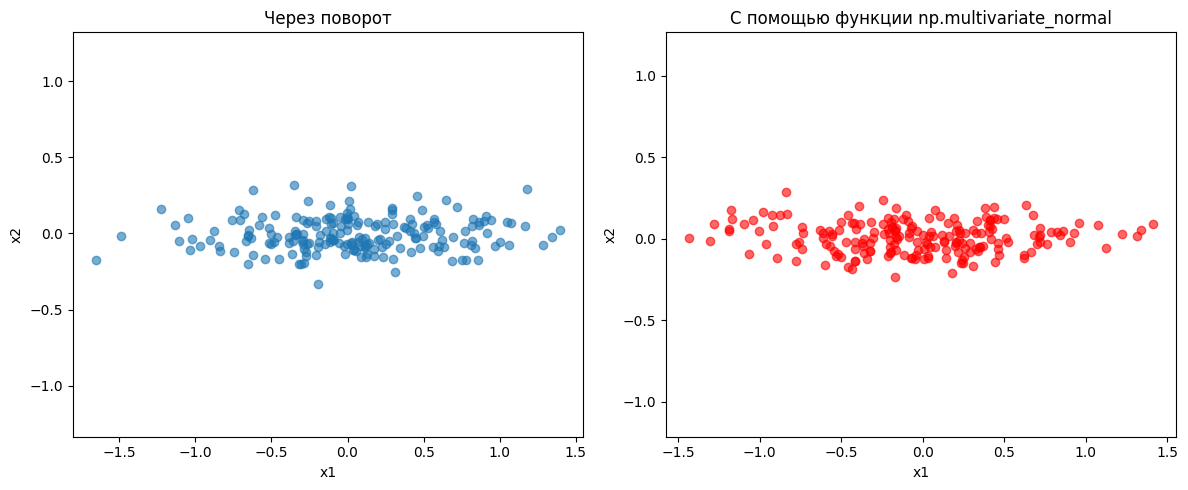

In [12]:
import numpy as np
import matplotlib.pyplot as plt
M = 200 
sigma1 = 0.1
sigma2 = 0.5
x1 = np.random.randn(M, 1) * sigma1 
x2 = np.random.randn(M, 1) * sigma2
X = np.concatenate((x1, x2), axis=1)

alpha = np.pi / 2
rotation_matrix = np.array([[np.cos(alpha), -np.sin(alpha)],
                           [np.sin(alpha), np.cos(alpha)]])
X_rotated = X @ rotation_matrix.T

cov_matrix = np.cov(X_rotated.T)
print("Матрица ковариации после поворота:")
print(cov_matrix)

mean = [0, 0]
cov = [[sigma1**2, 0], [0, sigma2**2]]
X_multivariate = np.random.multivariate_normal(mean, cov, M) @ rotation_matrix.T
cov_matrix_multivariate = np.cov(X_multivariate.T)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], alpha=0.6)
plt.title('Через поворот')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(X_multivariate[:, 0], X_multivariate[:, 1], alpha=0.6, color='red')
plt.title('С помощью функции np.multivariate_normal')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

plt.tight_layout()
plt.show()

### 2. Плотность вероятности гауссового распределения
В общем виде $n$-мерное гауссово распределение имеет вид:  
$$p(x) = \frac{1}{(\sqrt{2\pi})^n \sqrt{detC}} e^{-\frac{1}{2}(x-\mu)^TС^{-1}(x-\mu)} \tag{1}$$  
где $x\in{R^n}$, $\mu\in{R^n}$ - среднее значение, $C$ - матрица ковариации.  

Сгенерируйте набор точек в двумерном пространстве (как делали в пункте 1 или другим способом). Посчитайте для них среднее значение и матрицу ковариации $\mu$ и $C$. Для оценки плотности вероятности (probability density function - `pdf`) гауссового распределения в произвольной точке используйте `scipy.stats.multivariate_normal` 
(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html), либо можете посчитать вручную.  

Визуализируйте набор точек и плотность вероятности, для чего изобразите точки одним цветом, а фон раскрасьте в соответсвии с плотностью вероятности, для чего можете использовать пример ниже:  

``` python
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

xx = np.linspace(-1, 1, 100)
yy = np.linspace(-1, 1, 100)
XX, YY = np.meshgrid(xx, yy)
pp = np.stack((XX.flatten(), YY.flatten()), axis=1)
m = multivariate_normal(mean=[0,0], cov=[[0.3, 0], [0, 0.1]])
ZZ = m.pdf(pp).reshape(XX.shape)

IMG = plt.pcolor(XX, YY, ZZ)
plt.colorbar(IMG)

CS = plt.contour(XX, YY, m.pdf(pp).reshape(XX.shape), levels=[0.2, 0.4, 0.6, 0.8, 0.9], colors='k')
plt.clabel(CS, inline=1, fontsize=10)
```

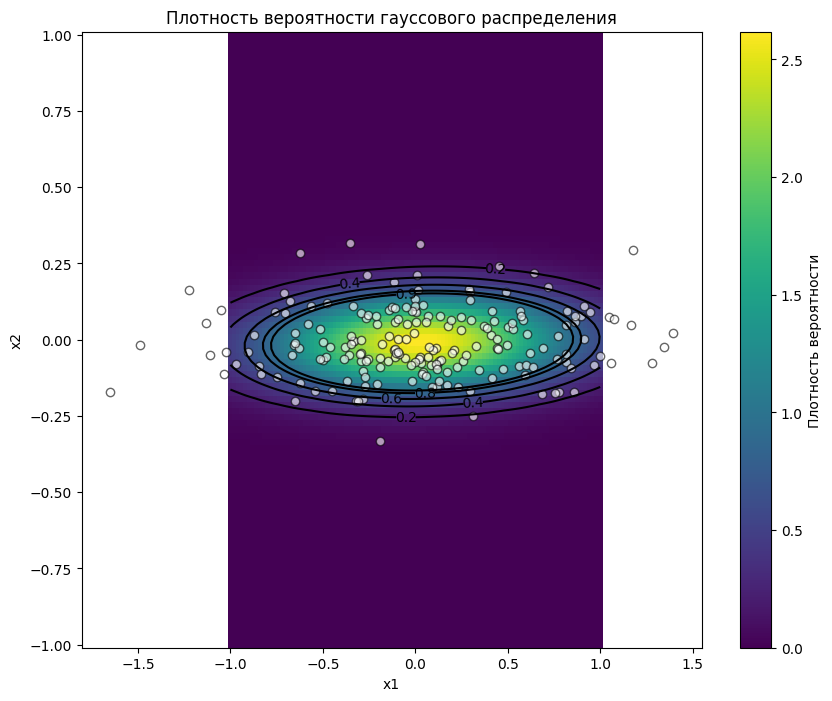

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

mean_estimated = np.mean(X_rotated, axis=0)
cov_estimated = np.cov(X_rotated.T)

xx = np.linspace(-1, 1, 100)
yy = np.linspace(-1, 1, 100)
XX, YY = np.meshgrid(xx, yy)
pp = np.stack((XX.flatten(), YY.flatten()), axis=1)

m = multivariate_normal(mean=mean_estimated, cov=cov_estimated)
ZZ = m.pdf(pp).reshape(XX.shape)

plt.figure(figsize=(10, 8))
IMG = plt.pcolor(XX, YY, ZZ, cmap='viridis')
plt.colorbar(IMG, label='Плотность вероятности')

CS = plt.contour(XX, YY, ZZ, levels=[0.2, 0.4, 0.6, 0.8, 0.9], colors='k')
plt.clabel(CS, inline=1, fontsize=10)

plt.scatter(X_rotated[:, 0], X_rotated[:, 1], alpha=0.6, color='white', edgecolors='black')
plt.title('Плотность вероятности гауссового распределения')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### 3. Бинарная классификация

**Задание** 
Создайте случайный датасет, состоящий из двух классов $y\in{\{0, 1\}}$, а признаки имеют две координаты. Посчитайте для каждого класса среднее значение и матрицу ковариации $\mu_0, \mu_1$ и $C_0, C_1$.

Решение задачи классификации можно свести к оценке максимальной апостериорной вероятности (Maximum a posterior - MAP):
$$y = \underset{y\in{0,1}}{argmax} p(y|x) \tag{2}$$  
которая в свою очередь через теорему Байеса равна:  
$$p(y|x) = \frac{p(x|y)p(y)}{p(x)} \tag{3}$$
В последней формуле вероятность p(y) называется априорной и не зависит от $x$ - оценить её можно просто как долю точек датасета принадлежащего заданному классу $y$. Вероятность p(x|y) называют правдоподобием (likelyhood). Обычно правдоподобие моделируется некоторой генерирующей моделью, например по формуле гаусса (1), и говорит насколько правдоподобно что точка с координатами $x$ могла быть "сгенерирована" в классе $y$. Знаменатель $p(x)$ в последней формуле не зависит от $y$, поэтому на него внимание не обращаем.  

Таким образом, для бинарной классификации, т.е. для оценки принадлежности некоторой точки $x$ к классу 0 или 1, нужно сравнить две величины:  
$$p(x|y=0)p(y=0) \overset{?}{<>} p(x|y=1)p(y=1) \tag{4}$$

**Задание**
Визуализируейте на одном рисунке датасет с точками обоих классов разными цветами. Раскрасьте фон изображения в соответствии с разностью левой и правой частей уравнения (4). Постройте на этом же рисунке разделяющую кривую, т.е. кривую соответствующую нулевой разнице между левой и правой частями. Для её построения используйте функции `plt.contour` с указанием конкретного уровня.

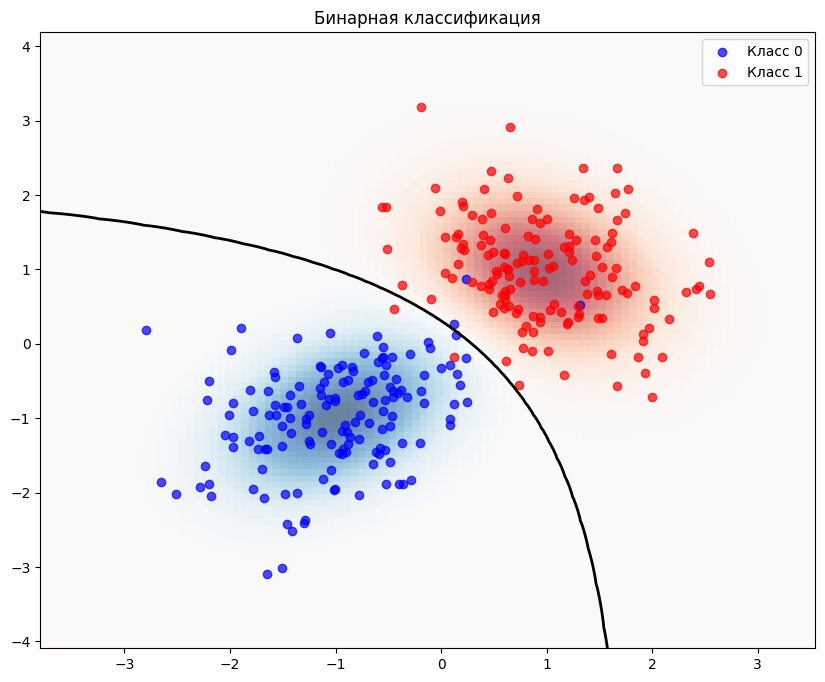

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(42)
n_samples = 300

# Класс 0
mean0 = [-1, -1]
cov0 = [[0.5, 0.2], [0.2, 0.5]]
X0 = np.random.multivariate_normal(mean0, cov0, n_samples//2)
y0 = np.zeros(n_samples//2)

# Класс 1
mean1 = [1, 1]
cov1 = [[0.5, -0.1], [-0.1, 0.5]]
X1 = np.random.multivariate_normal(mean1, cov1, n_samples//2)
y1 = np.ones(n_samples//2)

X_binary = np.vstack((X0, X1))
y_binary = np.hstack((y0, y1))

mu0 = np.mean(X0, axis=0)
mu1 = np.mean(X1, axis=0)
C0 = np.cov(X0.T)
C1 = np.cov(X1.T)

p0 = len(X0) / len(X_binary)
p1 = len(X1) / len(X_binary)

def decision_function(x):
    # Правдоподобие для класса 0
    likelihood0 = multivariate_normal(mu0, C0).pdf(x)
    # Правдоподобие для класса 1
    likelihood1 = multivariate_normal(mu1, C1).pdf(x)
    return likelihood0 * p0 - likelihood1 * p1

x_min, x_max = X_binary[:, 0].min() - 1, X_binary[:, 0].max() + 1
y_min, y_max = X_binary[:, 1].min() - 1, X_binary[:, 1].max() + 1
xx = np.linspace(x_min, x_max, 100)
yy = np.linspace(y_min, y_max, 100)
XX, YY = np.meshgrid(xx, yy)
grid_points = np.c_[XX.ravel(), YY.ravel()]

Z = decision_function(grid_points).reshape(XX.shape)

plt.figure(figsize=(10, 8))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin='lower', 
           cmap='RdBu', alpha=0.6, aspect='auto')
plt.scatter(X0[:, 0], X0[:, 1], c='blue', alpha=0.7, label='Класс 0')
plt.scatter(X1[:, 0], X1[:, 1], c='red', alpha=0.7, label='Класс 1')

CS = plt.contour(XX, YY, Z, levels=[0], colors='black', linewidths=2)

plt.title('Бинарная классификация')
plt.legend()
plt.show()

### 4. LDA (linear discriminant analysis)

**Задание** Рассмотрите частный случай, когда для точек двух классов матрицы ковариации совпадают, т.е. $C_0=C_1$, но средние значения отличаются $\mu_0\neq\mu_1$. Выпишите явное выражение для разделяющей поверхности в этом случае. Визуализируйте такой случай аналогично предыдущему пункту. Про линейный и квадратичный дискриминантный анализ можете почитать здесь (https://scikit-learn.org/stable/modules/lda_qda.html) или в учебнике Яндекса по ML (https://education.yandex.ru/handbook/ml/article/generativnyj-podhod-k-klassifikacii)

Реализуйте классификатор на основе метода линейного дискриминантного анализа по шаблону ниже. Данный алгоритм предполагает одинаковость матриц ковариации (т.е. считает одну общую матрицу ковариации, но разные средние) и использует линейное правило классификации. Желательно сделать реализацию, которая подходит не только для двумерного, но и для более общего случая.

```python
from sklearn.base import BaseEstimator

class myLDA(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        pass
```


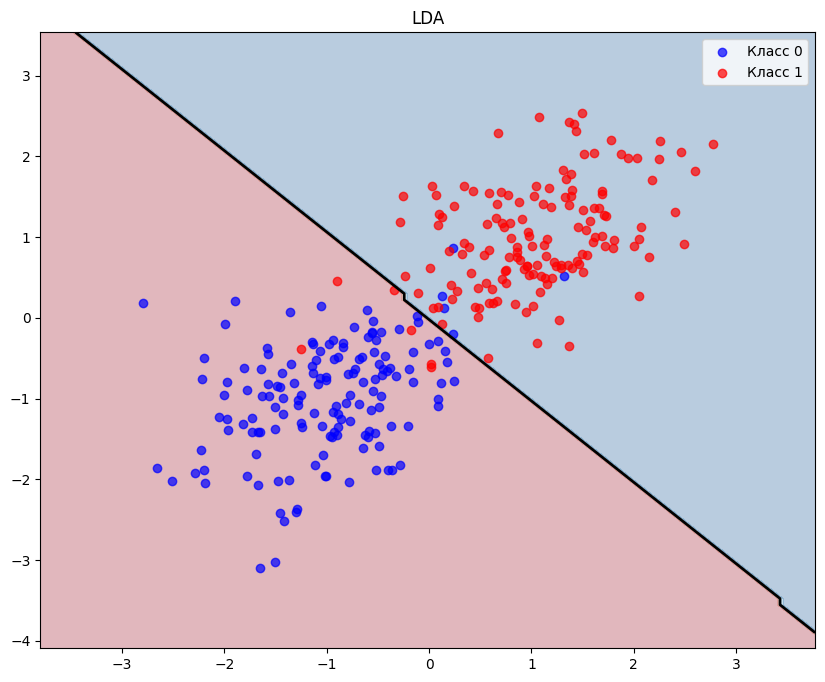

In [38]:
import numpy as np
import matplotlib.pyplot as plt

class myLDA:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        
        self.priors_ = np.array([np.mean(y == c) for c in self.classes_])
        
        self.means_ = np.array([X[y == c].mean(axis=0) for c in self.classes_])
        
        self.covariance_ = np.zeros((n_features, n_features))
        for c in self.classes_:
            X_c = X[y == c]
            self.covariance_ += np.cov(X_c.T, bias=True) * len(X_c)
        self.covariance_ /= len(X)
        
        return self
    
    def predict(self, X):
        discriminants = []
        cov_inv = np.linalg.inv(self.covariance_)
        
        for i, c in enumerate(self.classes_):
            linear_part = X @ cov_inv @ self.means_[i]
            quadratic_part = -0.5 * self.means_[i] @ cov_inv @ self.means_[i].T
            log_prior = np.log(self.priors_[i])
            
            discriminant = linear_part + quadratic_part + log_prior
            discriminants.append(discriminant)
        
        return self.classes_[np.argmax(np.array(discriminants).T, axis=1)]
    
np.random.seed(42)
n_samples = 300
common_cov = [[0.5, 0.2], [0.2, 0.5]]

# Класс 0
mean0_lda = [-1, -1]
X0_lda = np.random.multivariate_normal(mean0_lda, common_cov, n_samples//2)
y0_lda = np.zeros(n_samples//2)

# Класс 1
mean1_lda = [1, 1]
X1_lda = np.random.multivariate_normal(mean1_lda, common_cov, n_samples//2)
y1_lda = np.ones(n_samples//2)

X_lda = np.vstack((X0_lda, X1_lda))
y_lda = np.hstack((y0_lda, y1_lda))

lda = myLDA()
lda.fit(X_lda, y_lda)

x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

Z = lda.predict(grid_points).reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
plt.scatter(X0_lda[:, 0], X0_lda[:, 1], c='blue', alpha=0.7, label='Класс 0')
plt.scatter(X1_lda[:, 0], X1_lda[:, 1], c='red', alpha=0.7, label='Класс 1')

CS = plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

plt.title('LDA')
plt.legend()
plt.show()

### 5. Наивный байесовый классификатор (NaiveBayes)

**Задание** 
Прочитать по наивный байесовый подход можно здесь (https://scikit-learn.org/stable/modules/naive_bayes.html) или в учебнике Яндекса по ML (https://education.yandex.ru/handbook/ml/article/generativnyj-podhod-k-klassifikacii).  

Суть наивного предположения состоит в том, чтобы не считать совместную плотность вероятности для $n$-мерного случая, а рассматривать каждую переменную как независимую и считать одномерные распределения:  
$$p(x_1,x_2,...,x_n|y) => \prod\limits_{i=1}^{n}p(x_i|y)$$  
Это можно также рассматривать как обнуление всех внедиагональных элементов матрицы ковариации.  

**Задание** 
Реализуйте классификатор на основе наивного байесового подхода с одномерным гауссовым распределением для каждой переменной. Желательно сделать реализацию, которая подходит не только для двумерного, но и для более общего случая.

```python
from sklearn.base import BaseEstimator

class myNB(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        pass
```

In [44]:
import numpy as np
from sklearn.base import BaseEstimator

class myNB(BaseEstimator):
    def __init__(self):
       pass
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        
        self.priors_ = np.array([np.mean(y == c) for c in self.classes_])
        
        self.means_ = np.zeros((n_classes, n_features))
        self.variances_ = np.zeros((n_classes, n_features))
        
        for i, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.means_[i] = X_c.mean(axis=0)
            self.variances_[i] = X_c.var(axis=0, ddof=0)  
        
        return self
    
    def _gaussian_density(self, x, mean, var):
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x - mean)**2 / (2 * var))
    
    def predict(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        probabilities = np.zeros((n_samples, n_classes))
        
        for i in range(n_classes):
            log_prior = np.log(self.priors_[i])
            
            log_likelihood = np.zeros(n_samples)
            for j in range(X.shape[1]):
                log_likelihood += np.log(self._gaussian_densityf(X[:, j], 
                                                          self.means_[i, j], 
                                                          self.variances_[i, j]) + 1e-10)
            
            probabilities[:, i] = log_prior + log_likelihood
        
        probabilities = np.exp(probabilities)
        probabilities /= probabilities.sum(axis=1, keepdims=True)
        
        return probabilities
    
    def predict(self, X):
        probabilities = self.predict(X)
        return self.classes_[np.argmax(probabilities, axis=1)]

### 6. Сравнение двух алгоритмов: LDA и NB

Создайте датасет для бинарной классификации, либо вручную либо используйте функцию `sklearn.datasets.make_classification`
(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)  

Разделите датасет на обучающую и тестовую подвыборки.  
Проверьте работоспособность разработанных вами двух алгоритмов.  
Посчитайте основные метрики классификации: долю правильных ответов (accuracy), точность (Precision) и полноту (Recall).  
(про метрики прочитайте здесь https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii)  
Сделайте выводы.  

In [61]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X, y = make_classification(
    n_samples=300,
    n_features=5,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)
lda = LDA()
nb = GaussianNB()

lda.fit(X_train, y_train)
nb.fit(X_train, y_train)

y_pred_lda = lda.predict(X_test)
y_pred_nb = nb.predict(X_test)

def evaluate(y_true, y_pred, name):
    print(f"\n{name}:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))

evaluate(y_test, y_pred_nb, "Naive Bayes")
evaluate(y_test, y_pred_lda, "LDA")
    


Naive Bayes:
Accuracy : 0.875
Precision: 0.8870967741935484
Recall   : 0.873015873015873

LDA:
Accuracy : 0.8916666666666667
Precision: 0.8787878787878788
Recall   : 0.9206349206349206
